In [3]:
import pandas as pd
import tensorflow as tf
data = pd.read_csv('train.csv')
data_na = pd.read_csv("test.csv")

In [4]:
from sklearn.model_selection import train_test_split
X_data = data.drop('label',axis=1)
data_na = data_na/255.0
y_data = data['label']
X_data = X_data/255.0
y_data = y_data
X_train, X_test, y_train, y_test = train_test_split(X_data,y_data,test_size=0.2, random_state=0)

In [174]:
# Parameters
learning_rate = 0.001
training_iters = 10 * X_train.shape[0]
batch_size = 128
display_step = 100

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

In [6]:
def error_rate(predictions, labels):
  """Return the error rate based on dense predictions and sparse labels."""
  return 100.0 - (
      100.0 *
      numpy.sum(numpy.argmax(predictions, 1) == labels) /
      predictions.shape[0])

In [7]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.int64, (None,))
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [8]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [9]:
def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')


In [10]:
# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    #fully connected 1024 to 256
    fc2 = tf.add(tf.matmul(fc1,weights['wd2']),biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2,dropout)
    # Output, class prediction
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return out

In [11]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 32],stddev=0.1)),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.truncated_normal([5, 5, 32, 64],stddev=0.1)),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.truncated_normal([7*7*64, 1024],stddev=0.1)),
    # fully connected, 1024 inputs, 256 outputs
    'wd2': tf.Variable(tf.truncated_normal([1024,256],stddev=0.1)),
    # 256 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.truncated_normal([256, n_classes],stddev=0.1))
}

biases = {
    'bc1': tf.Variable(tf.truncated_normal([32],stddev=0.1)),
    'bc2': tf.Variable(tf.truncated_normal([64],stddev=0.1)),
    'bd1': tf.Variable(tf.truncated_normal([1024],stddev=0.1)),
    'bd2': tf.Variable(tf.truncated_normal([256],stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([n_classes],stddev=0.1))
}

In [12]:
import time
import numpy
import sys
import random
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
%matplotlib inline

Iter :,0.00, Minibatch Loss= 4.461624, Training Accuracy= 0.20312
Iter :100,0.38, Minibatch Loss= 0.136753, Training Accuracy= 0.95312
Iter :200,0.76, Minibatch Loss= 0.091208, Training Accuracy= 0.97656
Iter :300,1.14, Minibatch Loss= 0.020163, Training Accuracy= 0.99219
Iter :400,1.52, Minibatch Loss= 0.024872, Training Accuracy= 0.99219
Iter :500,1.90, Minibatch Loss= 0.026697, Training Accuracy= 0.99219
Iter :600,2.29, Minibatch Loss= 0.012894, Training Accuracy= 1.00000
Iter :700,2.67, Minibatch Loss= 0.029908, Training Accuracy= 0.98438
Iter :800,3.05, Minibatch Loss= 0.012798, Training Accuracy= 0.99219
Iter :900,3.43, Minibatch Loss= 0.003755, Training Accuracy= 1.00000
Iter :1000,3.81, Minibatch Loss= 0.031905, Training Accuracy= 0.99219
Iter :1100,4.19, Minibatch Loss= 0.006126, Training Accuracy= 1.00000
Iter :1200,4.57, Minibatch Loss= 0.000903, Training Accuracy= 1.00000
Iter :1300,4.95, Minibatch Loss= 0.003760, Training Accuracy= 1.00000
Iter :1400,5.33, Minibatch Loss= 

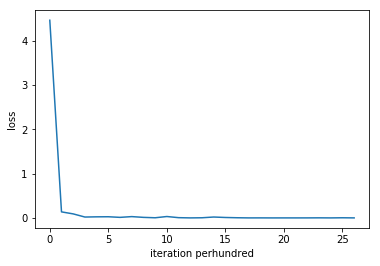

('test accuracy is:', 0.99060059)


In [175]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=y))
regularizations = (tf.nn.l2_loss(weights['wd1'])+tf.nn.l2_loss(weights['wd2'])+
                  tf.nn.l2_loss(weights['out'])+tf.nn.l2_loss(biases['bd1'])+
                  tf.nn.l2_loss(biases['bd2'])+tf.nn.l2_loss(biases['out']))
#cost += 5e-4 * regularizations
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    step = 0
    offset = 0
    lossed = []
    accs = []
    preds = []
    index = range(X_train.shape[0])
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        if offset > (X_train.shape[0]-batch_size):
            random.shuffle(index)
        offset = offset%(X_train.shape[0]-batch_size)
        batch_x = X_train.iloc[index[offset:(offset + batch_size)], :]
        batch_y = y_train.iloc[index[offset:(offset + batch_size)]]
        offset = offset + batch_size
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            lossed.append(loss)
            print("Iter :%.d,%.2f"%(step,1.0*step*batch_size/X_train.shape[0]) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")
    plt.plot(numpy.squeeze(lossed))
    plt.xlabel('iteration perhundred')
    plt.ylabel('loss')
    plt.show()
    # Calculate accuracy for 256 mnist test images
    for i in range(X_test.shape[0]/batch_size-1):
        acc = sess.run(accuracy, feed_dict={x: X_test[i*batch_size:(i+1)*batch_size],
                                            y: y_test[i*batch_size:(i+1)*batch_size],
                                            keep_prob: 1.})
        accs.append(acc)
    print("test accuracy is:",numpy.mean(accs))
    for i in range(data_na.shape[0]/140):
        pred_test = sess.run(pred, feed_dict={x:data_na[i*140:(i+1)*140],
                                         y:y_train[i*140:(i+1)*140],
                                         keep_prob: 1.})
        preds.append(numpy.argmax(pred_test,axis=1))
    preds = numpy.reshape(preds,[-1,1])
    preds = numpy.squeeze(preds)
